Q)Design a simple neural network with  Batch Normalization layer in the hidden layer, and another without Batch Normalization in the hidden layers. Then plot a contour plot to vizualize the loss landscapes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


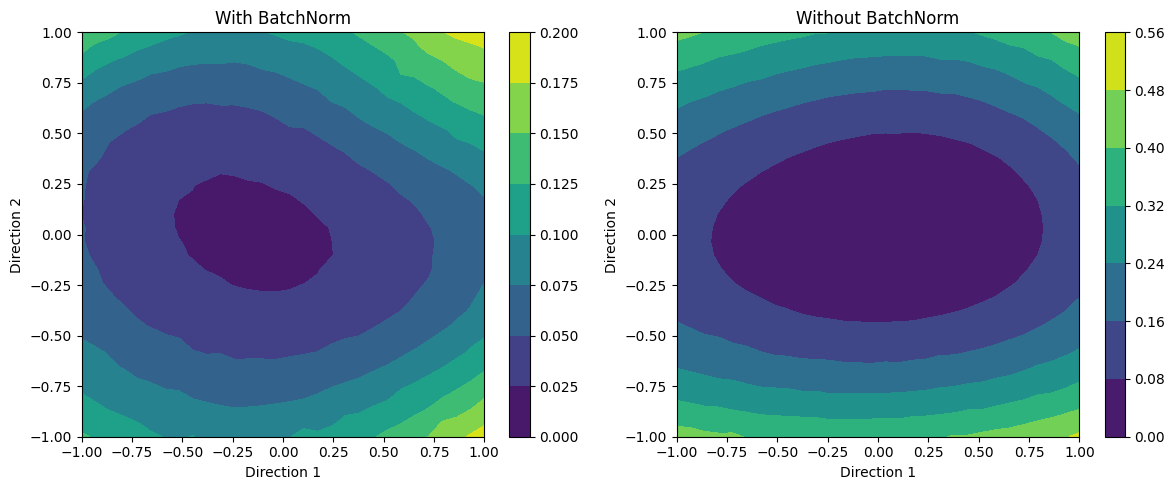

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Generate synthetic dataset
x_data = np.random.randn(500, 2).astype(np.float32)
y_data = (x_data[:, 0] * x_data[:, 1]).reshape(-1, 1).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(500).batch(32)

# Define models
def build_model_with_bn():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, input_shape=(2,), use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1)
    ])
    return model

def build_model_without_bn():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, input_shape=(2,), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

# Training function
def train_model(model, dataset, epochs=100, lr=0.01):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.MeanSquaredError()

    for epoch in range(epochs):
        for x_batch, y_batch in dataset:
            with tf.GradientTape() as tape:
                preds = model(x_batch, training=True)
                loss = loss_fn(y_batch, preds)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return model

# Train models
model_bn = train_model(build_model_with_bn(), dataset)
model_no_bn = train_model(build_model_without_bn(), dataset)

# Function to compute loss landscape
def compute_loss_landscape(model, dataset, perturb_range=(-1, 1), steps=30):
    w1 = model.trainable_variables[0].numpy()
    w2 = model.trainable_variables[1].numpy()

    u = np.random.randn(*w1.shape)
    v = np.random.randn(*w2.shape)
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)

    loss_surface = np.zeros((steps, steps))
    alphas = np.linspace(*perturb_range, steps)
    betas = np.linspace(*perturb_range, steps)

    original_weights = [var.numpy() for var in model.trainable_variables]

    loss_fn = tf.keras.losses.MeanSquaredError()

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            model.trainable_variables[0].assign(w1 + alpha * u)
            model.trainable_variables[1].assign(w2 + beta * v)
            losses = []
            for xb, yb in dataset:
                preds = model(xb, training=False)
                losses.append(loss_fn(yb, preds).numpy())
            loss_surface[i, j] = np.mean(losses)

    # Restore original weights
    for var, orig in zip(model.trainable_variables, original_weights):
        var.assign(orig)

    return loss_surface

# Compute loss landscapes
loss_bn = compute_loss_landscape(model_bn, dataset)
loss_no_bn = compute_loss_landscape(model_no_bn, dataset)

# Plot contour maps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, loss, title in zip(axes, [loss_bn, loss_no_bn], ['With BatchNorm', 'Without BatchNorm']):
    cs = ax.contourf(np.linspace(-1, 1, 30), np.linspace(-1, 1, 30), loss, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Direction 1')
    ax.set_ylabel('Direction 2')

plt.tight_layout()
plt.show()
